#  Malware detection

<h2>Data</h2>

 Source : https://www.kaggle.com/c/malware-classification/data 
 
 
<li> For every malware, we have - <ol> <li>.bytes file (the raw data contains the hexadecimal representation of the file's binary content, without the PE header)</li></ol></li> 
    
<li>Training data has 200GB .bytes files </li>

<li>There are total 10,868 .bytes files  </li>

<li>There are 9 types of malwares (9 classes) in our give data</li>
<li> Types of Malware:
    <ol>
        <li> Ramnit </li>
        <li> Lollipop </li>
        <li> Kelihos_ver3 </li>
        <li> Vundo </li>
        <li> Simda </li>
        <li> Tracur </li>
        <li> Kelihos_ver1 </li>
        <li> Obfuscator.ACY </li>
        <li> Gatak </li>
    </ol>
</li>

<h2> ML problem</h2>

<p>
    
There are nine different classes of malware that we need to classify a given a data point => Multi class classification problem    
</p>

<h3> Performance Metric</h3>

Source: https://www.kaggle.com/c/malware-classification#evaluation

Metric(s): 
* Multi class log-loss 
* Confusion matrix 


<h1>Exploratory Data Analysis</h1>

In [3]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

<h2>Distribution of malware classes in whole data set </h2>

<IPython.core.display.Javascript object>


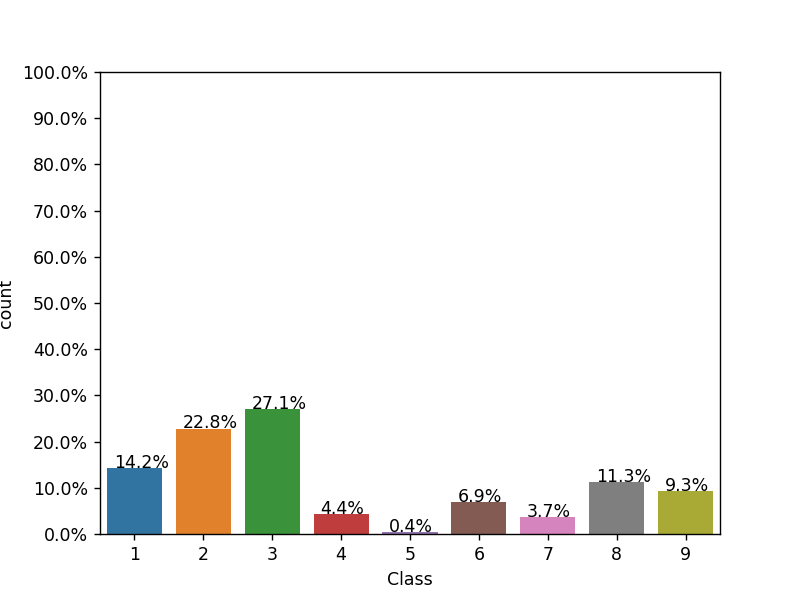

In [84]:
Y = pd.read_csv("trainLabels.csv")
total = len(Y) * 1
ax = sns.countplot(x="Class", data=Y)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100 * p.get_height() / total),
                (p.get_x() + 0.1, p.get_height() + 5))

# Add 11 ticks (therefore 10 steps) from 0 to the total number of rows in the data frame
ax.yaxis.set_ticks(np.linspace(0, total, 11))

# adjust the tick label to the desired format, without changing the position of the ticks.
ax.set_yticklabels(map('{:.1f}%'.format, 100 * ax.yaxis.get_majorticklocs() / total))
plt.show()

<h2> Feature extraction </h2>

<h3> Adding file size as a feature </h3>

In [11]:

# Collect the sizes of file in bytes

files = os.listdir('byteFiles')
filenames = Y['Id'].tolist()
class_y = Y['Class'].tolist()
class_bytes = []
size_in_bytes = []
fnames = []
for file in files:
    file_stats = os.stat('byteFiles/' + file)
    file = file.split('.')[0]  # split the file name at '.' and take the first part of it i.e the file name
    if any(file == filename for filename in filenames):
        i = filenames.index(file)
        class_bytes.append(class_y[i])
        # File size in MB's
        size_in_bytes.append(file_stats.st_size / (1024.0 * 1024.0))
        fnames.append(file)
data_size_byte = pd.DataFrame({'ID': fnames, 'size': size_in_bytes, 'Class': class_bytes})
print(data_size_byte.head())


                     ID      size  Class
0  01azqd4InC7m9JpocGv5  5.012695      9
1  01IsoiSMh5gxyDYTl4CB  6.556152      2
2  01jsnpXSAlgw6aPeDxrU  4.602051      9
3  01kcPWA9K2BOxQeS5Rju  0.679688      1
4  01SuzwMJEIXsK7A8dQbl  0.438965      8


<h3> box plots of file size (.byte files) feature </h3>

<IPython.core.display.Javascript object>


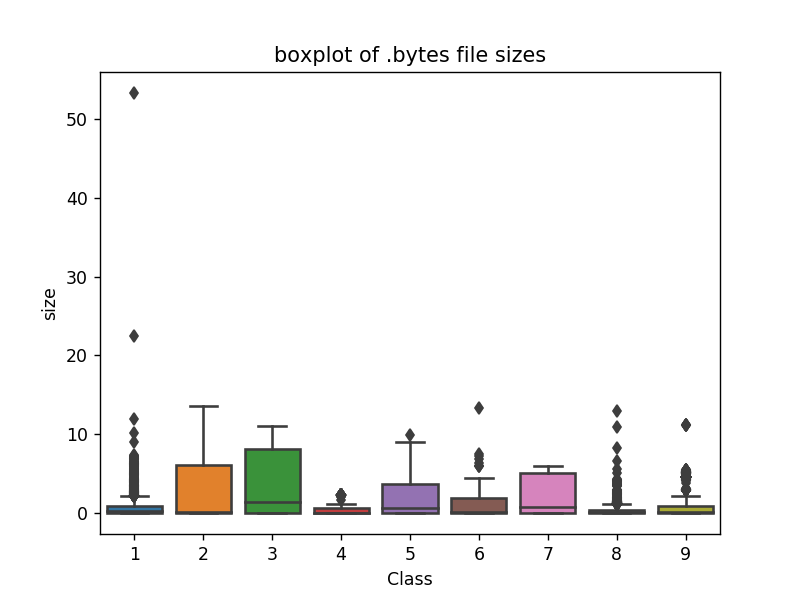

In [7]:
ax = sns.boxplot(x="Class", y="size", data=data_size_byte)
plt.title("boxplot of .bytes file sizes")
plt.show()

<h3>feature extraction from byte files </h3>

In [29]:
files = os.listdir('byteFiles')

#Remove the addres from byte files

filenames = []
array = []
for file in files:
    if file.endswith("bytes"):
        file = file.split('.')[0]
        text_file = open('byteFiles/' + file + ".txt", 'w+')
        with open('byteFiles/' + file + '.bytes', "r") as bytes_file:
            lines = ""
            for line in bytes_file:
                a = line.rstrip().split(" ")[1:]
                b = ' '.join(a)
                b = b + "\n"
                text_file.write(b)
            bytes_file.close()
        text_file.close()


In [32]:

k = 0
files = os.listdir('byteFiles_txt')
feature_matrix = np.zeros((len(files), 257), dtype=int)
all_file_names = []

# program to convert into bag of words of bytefiles
# this is custom-built bag of words this is unigram bag of words
file_with_byte_features = open('result.csv', 'w+')
file_with_byte_features.write(
    "ID,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,"
    "17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,"
    "2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,"
    "48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,"
    "61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,"
    "7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,"
    "93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,"
    "ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,"
    "c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,"
    "de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,"
    "f7,f8,f9,fa,fb,fc,fd,fe,ff,??")


def handle_counters():
    for hex_code in line:
        if hex_code == '??':
            feature_matrix[k][256] += 1
        else:
            feature_matrix[k][int(hex_code, 16)] += 1


for file in files:
    all_file_names.append(file)
    file_with_byte_features.write(file + ",")
    if file.endswith("txt"):
        with open('byteFiles/' + file, "r") as byte_flie:
            for lines in byte_flie:
                line = lines.rstrip().split(" ")
                handle_counters()
        byte_flie.close()
    for i in feature_matrix[k]:
        file_with_byte_features.write(str(i) + ",")
    file_with_byte_features.write("\n")

    k += 1

file_with_byte_features.close()

In [58]:
byte_features=pd.read_csv("result.csv", index_col = False)

In [59]:
byte_features.head()

,ID,0,1,2,3,4,5,6,7,8,...,f7,f8,f9,fa,fb,fc,fd,fe,ff,??
0,01azqd4InC7m9JpocGv5,601905,3905,2816,3832,3345,3242,3650,3201,2965,...,2804,3687,3101,3211,3097,2758,3099,2759,5753,1824
1,01IsoiSMh5gxyDYTl4CB,39755,8337,7249,7186,8663,6844,8420,7589,9291,...,451,6536,439,281,302,7639,518,17001,54902,8588
2,01jsnpXSAlgw6aPeDxrU,93506,9542,2568,2438,8925,9330,9007,2342,9107,...,2325,2358,2242,2885,2863,2471,2786,2680,49144,468
3,01kcPWA9K2BOxQeS5Rju,21091,1213,726,817,1257,625,550,523,1078,...,478,873,485,462,516,1133,471,761,7998,13940
4,01SuzwMJEIXsK7A8dQbl,19764,710,302,433,559,410,262,249,422,...,847,947,350,209,239,653,221,242,2199,9008


In [60]:
result = pd.merge(byte_features, data_size_byte, on='ID', how='left')
result.head()

,ID,0,1,2,3,4,5,6,7,8,...,f9,fa,fb,fc,fd,fe,ff,??,size,Class
0,01azqd4InC7m9JpocGv5,601905,3905,2816,3832,3345,3242,3650,3201,2965,...,3101,3211,3097,2758,3099,2759,5753,1824,5.012695,9
1,01azqd4InC7m9JpocGv5,601905,3905,2816,3832,3345,3242,3650,3201,2965,...,3101,3211,3097,2758,3099,2759,5753,1824,0.000000,9
2,01IsoiSMh5gxyDYTl4CB,39755,8337,7249,7186,8663,6844,8420,7589,9291,...,439,281,302,7639,518,17001,54902,8588,6.556152,2
3,01IsoiSMh5gxyDYTl4CB,39755,8337,7249,7186,8663,6844,8420,7589,9291,...,439,281,302,7639,518,17001,54902,8588,0.000000,2
4,01jsnpXSAlgw6aPeDxrU,93506,9542,2568,2438,8925,9330,9007,2342,9107,...,2242,2885,2863,2471,2786,2680,49144,468,4.602051,9


In [61]:

def normalize(df):
    normalized_result = df.copy()
    for feature_name in df.columns:
        if str(feature_name) != str('ID') and str(feature_name) != str('Class'):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            normalized_result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return normalized_result


result = normalize(result)


byte_features.to_pickle('byte_features.pkl')
data_size_byte.to_pickle('data_size_byte.pkl')
result.to_pickle('result_after_all_transfroms.pkl')


In [4]:

byte_features = pd.read_pickle('byte_features.pkl')
data_size_byte = pd.read_pickle('data_size_byte.pkl')
result = pd.read_pickle('result_after_all_transfroms.pkl')

data_y = result['Class']

result.head()


,ID,0,1,2,3,4,5,6,7,8,...,f9,fa,fb,fc,fd,fe,ff,??,size,Class
0,01azqd4InC7m9JpocGv5,0.262806,0.005498,0.001567,0.002067,0.002048,0.001835,0.002058,0.002946,0.002638,...,0.013560,0.013107,0.013634,0.031724,0.014549,0.014348,0.007843,0.000129,0.094049,9
1,01azqd4InC7m9JpocGv5,0.262806,0.005498,0.001567,0.002067,0.002048,0.001835,0.002058,0.002946,0.002638,...,0.013560,0.013107,0.013634,0.031724,0.014549,0.014348,0.007843,0.000129,0.000000,9
2,01IsoiSMh5gxyDYTl4CB,0.017358,0.011737,0.004033,0.003876,0.005303,0.003873,0.004747,0.006984,0.008267,...,0.001920,0.001147,0.001329,0.087867,0.002432,0.088411,0.074851,0.000606,0.123007,2
3,01IsoiSMh5gxyDYTl4CB,0.017358,0.011737,0.004033,0.003876,0.005303,0.003873,0.004747,0.006984,0.008267,...,0.001920,0.001147,0.001329,0.087867,0.002432,0.088411,0.074851,0.000606,0.000000,2
4,01jsnpXSAlgw6aPeDxrU,0.040827,0.013434,0.001429,0.001315,0.005464,0.005280,0.005078,0.002155,0.008104,...,0.009804,0.011777,0.012604,0.028423,0.013080,0.013937,0.067001,0.000033,0.086344,9


<h3>Multivariate Analysis </h3>

<IPython.core.display.Javascript object>


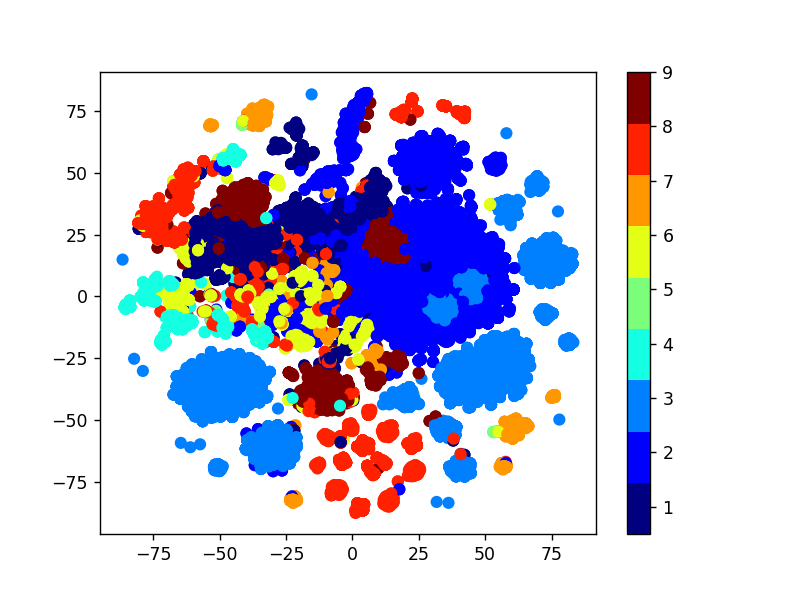

In [5]:

# Analysis on byte files - with perplexity 50

xtsne = TSNE(perplexity=50)
results = xtsne.fit_transform(result.drop(['ID', 'Class'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

<IPython.core.display.Javascript object>


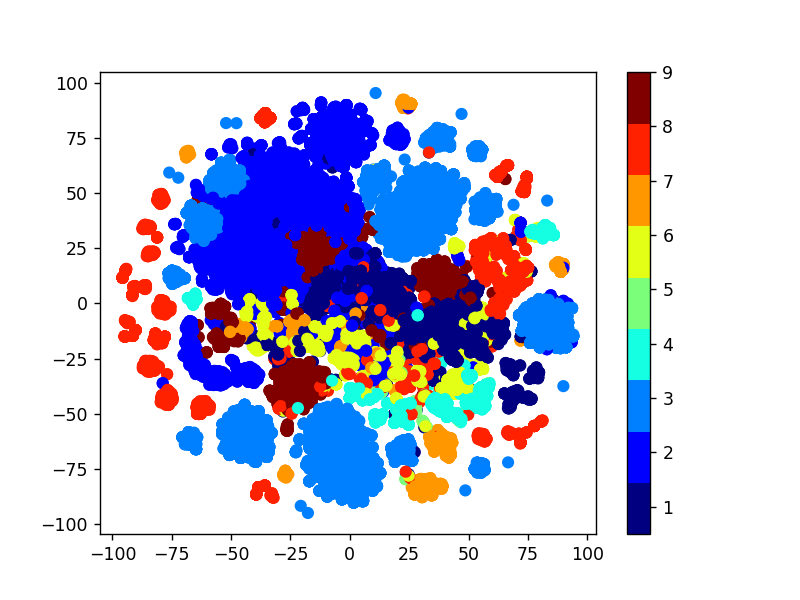

In [82]:
# with perplexity value - 30
xtsne=TSNE(perplexity=30)
results=xtsne.fit_transform(result.drop(['ID','Class'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.clim(0.5, 9)
plt.colorbar(ticks=range(10))
plt.show()

# Train Test split

In [6]:

data_y = result['Class']

# Train, test split
X_train, X_test, y_train, y_test = train_test_split(result.drop(['ID', 'Class'], axis=1),
                                                    data_y, stratify=data_y, test_size=0.20)

# Train, CV split
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train,
                                                test_size=0.20)

In [7]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 13910
Number of data points in test data: 4348
Number of data points in cross validation data: 3478


In train data


<IPython.core.display.Javascript object>


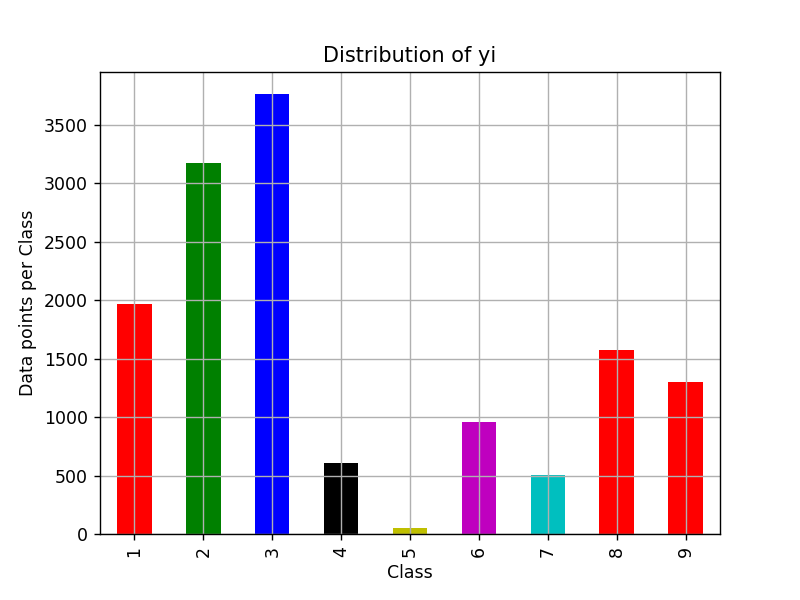

Number of data points in class 3 : 3765 ( 27.067 %)
Number of data points in class 2 : 3172 ( 22.804 %)
Number of data points in class 1 : 1972 ( 14.177 %)
Number of data points in class 8 : 1572 ( 11.301 %)
Number of data points in class 9 : 1297 ( 9.324 %)
Number of data points in class 6 : 961 ( 6.909 %)
Number of data points in class 4 : 608 ( 4.371 %)
Number of data points in class 7 : 509 ( 3.659 %)
Number of data points in class 5 : 54 ( 0.388 %)
In test data


<IPython.core.display.Javascript object>


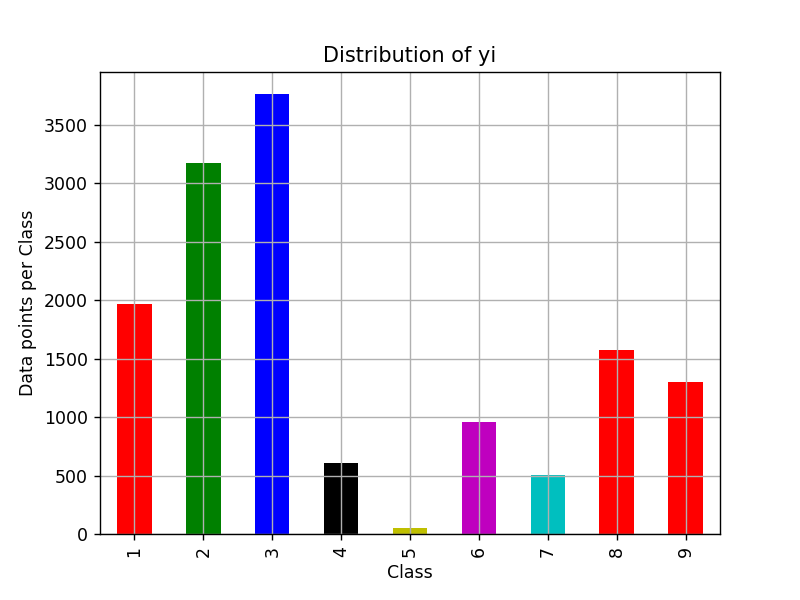

Number of data points in class 3 : 1177 ( 27.07 %)
Number of data points in class 2 : 991 ( 22.792 %)
Number of data points in class 1 : 617 ( 14.19 %)
Number of data points in class 8 : 491 ( 11.293 %)
Number of data points in class 9 : 405 ( 9.315 %)
Number of data points in class 6 : 301 ( 6.923 %)
Number of data points in class 4 : 190 ( 4.37 %)
Number of data points in class 7 : 159 ( 3.657 %)
Number of data points in class 5 : 17 ( 0.391 %)
In CV data


<IPython.core.display.Javascript object>


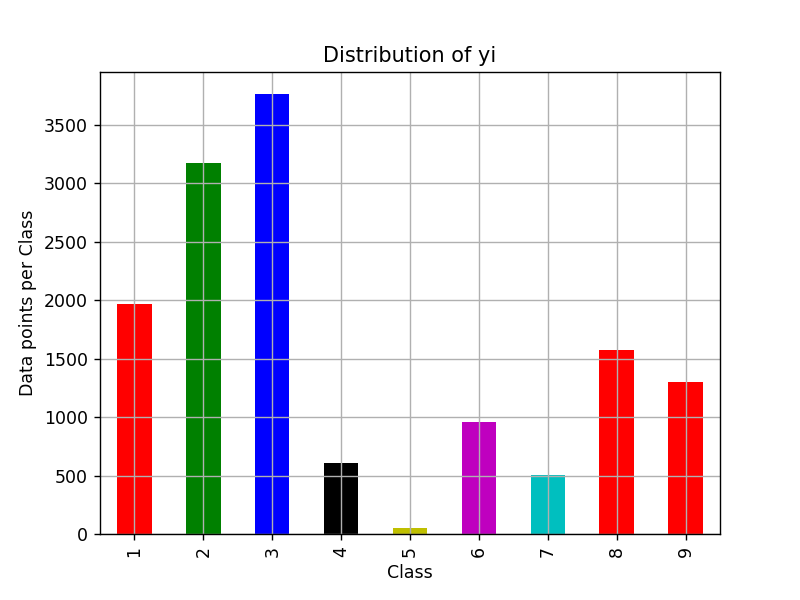

Number of data points in class 3 : 942 ( 27.085 %)
Number of data points in class 2 : 793 ( 22.8 %)
Number of data points in class 1 : 493 ( 14.175 %)
Number of data points in class 8 : 393 ( 11.3 %)
Number of data points in class 9 : 324 ( 9.316 %)
Number of data points in class 6 : 240 ( 6.901 %)
Number of data points in class 4 : 152 ( 4.37 %)
Number of data points in class 7 : 128 ( 3.68 %)
Number of data points in class 5 : 13 ( 0.374 %)


In [8]:

def plot_y_distribution():
    global my_colors
    my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
    train_class_distribution.plot(kind='bar', color=my_colors)
    plt.xlabel('Class')
    plt.ylabel('Data points per Class')
    plt.title('Distribution of yi')
    plt.grid()
    plt.show()


train_class_distribution = y_train.value_counts().sortlevel()
test_class_distribution = y_test.value_counts().sortlevel()
cv_class_distribution = y_cv.value_counts().sortlevel()

print('In train data')

plot_y_distribution()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i + 1, ':', train_class_distribution.values[i], '(',
          np.round((train_class_distribution.values[i] / y_train.shape[0] * 100), 3), '%)')

print('=' * 80)
print('In test data')
# 
# my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
# test_class_distribution.plot(kind='bar', color=my_colors)
# plt.xlabel('Class')
# plt.ylabel('Data points per Class')
# plt.title('Distribution of yi')
# plt.grid()
# plt.show()

plot_y_distribution()


sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i + 1, ':', test_class_distribution.values[i], '(',
          np.round((test_class_distribution.values[i] / y_test.shape[0] * 100), 3), '%)')

print('=' * 80)
print('In CV data')

# my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
# cv_class_distribution.plot(kind='bar', color=my_colors)
# plt.xlabel('Class')
# plt.ylabel('Data points per Class')
# plt.title('Distribution of yi')
# plt.grid()
# plt.show()
plot_y_distribution()


sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i + 1, ':', cv_class_distribution.values[i], '(',
          np.round((cv_class_distribution.values[i] / y_cv.shape[0] * 100), 3), '%)')


In [9]:

def plot_confusion_matrix(test_y, predicted_y):
    c = confusion_matrix(test_y, predicted_y)
    print("Number of misclassified points ", (len(test_y) - np.trace(c)) / len(test_y) * 100)

    a = (c.T / (c.sum(axis=1))).T

    b = c / c.sum(axis=0)

    labels = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    cmap = sns.light_palette("green")

    print("=" * 50, "Confusion matrix", "=" * 50)
    get_heat_map(c, cmap, labels)

    print("=" * 50, "Precision matrix", "=" * 50)
    get_heat_map(b, cmap, labels)

    print("=" * 50, "Recall matrix", "=" * 50)
    get_heat_map(a, cmap, labels)


def get_heat_map(c, cmap, labels):
    plt.figure(figsize=(10, 5))
    sns.heatmap(c, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.ylabel('Original Class')
    plt.xlabel('Predicted Class')
    plt.show()



<h1>Machine Learning Models</h1>

<h2>Machine Leaning Models on bytes files</h2>

<h3> Random Model</h3>

Log loss on Cross Validation Data using Random Model 2.4585822763614056
Log loss on Test Data using Random Model 2.483736724705465
Number of misclassified points  87.94848206071757
================================================== Confusion matrix ==================================================


<IPython.core.display.Javascript object>


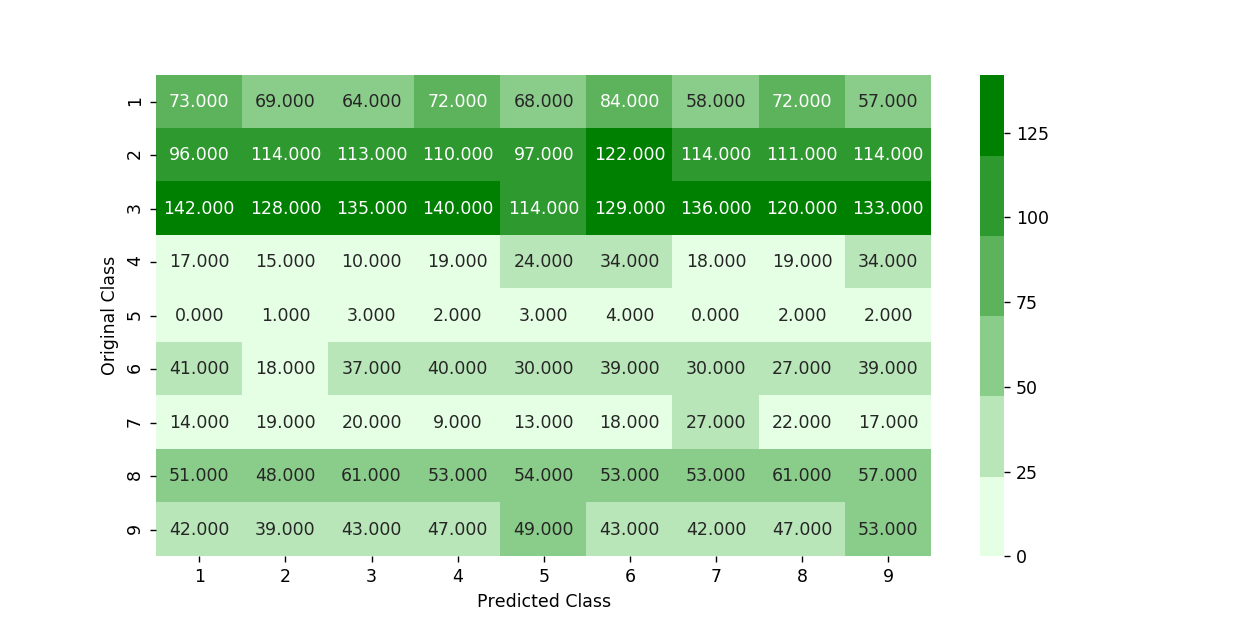

================================================== Precision matrix ==================================================


<IPython.core.display.Javascript object>


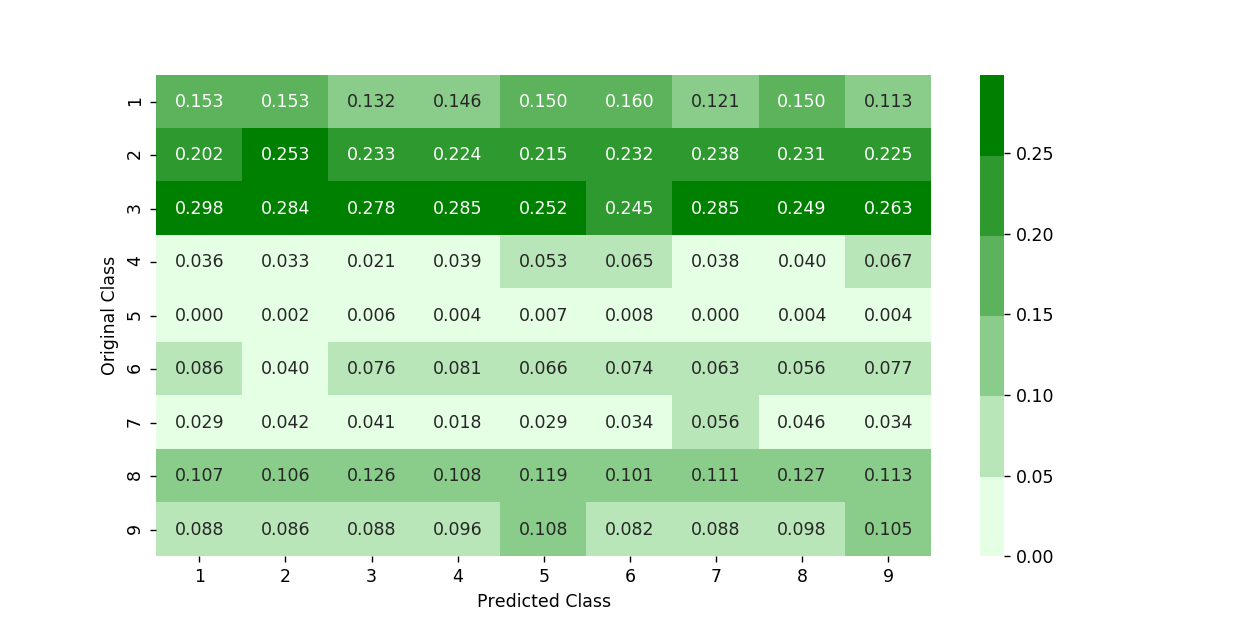

================================================== Recall matrix ==================================================


<IPython.core.display.Javascript object>


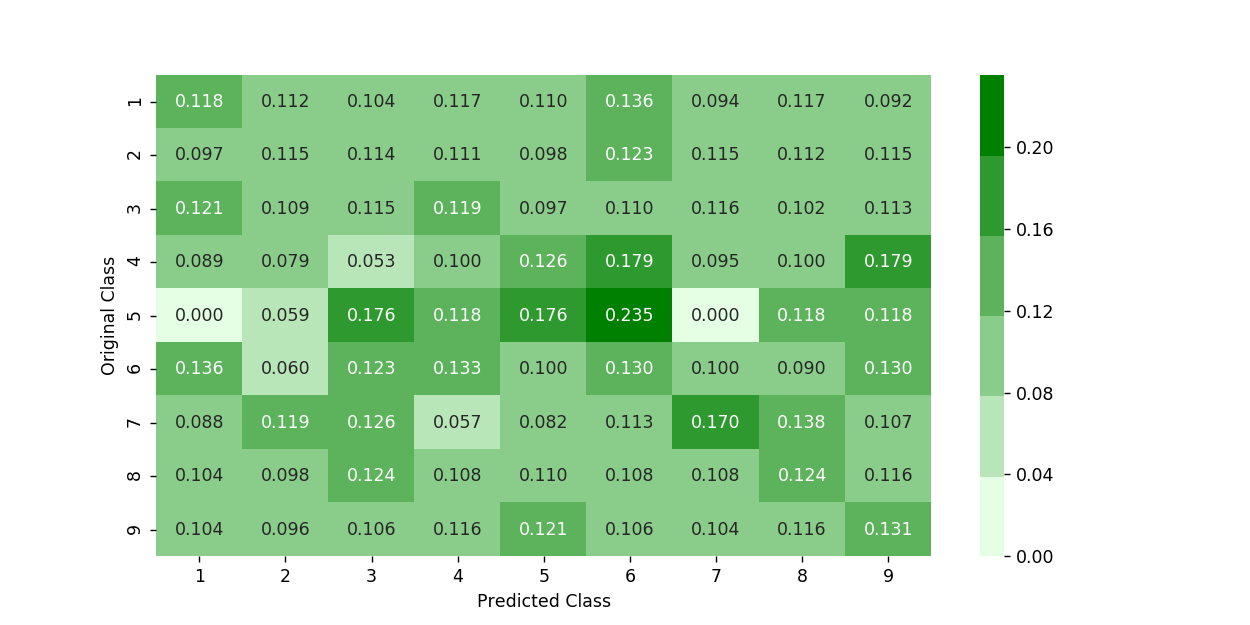

In [10]:

test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

cv_predicted_y = np.zeros((cv_data_len, 9))
for i in range(cv_data_len):
    rand_probabilities = np.random.rand(1, 9)
    cv_predicted_y[i] = ((rand_probabilities / sum(sum(rand_probabilities)))[0])
print("Log loss on Cross Validation Data using Random Model", log_loss(y_cv, cv_predicted_y, eps=1e-15))

test_predicted_y = np.zeros((test_data_len, 9))
for i in range(test_data_len):
    rand_probabilities = np.random.rand(1, 9)
    test_predicted_y[i] = ((rand_probabilities / sum(sum(rand_probabilities)))[0])
print("Log loss on Test Data using Random Model", log_loss(y_test, test_predicted_y, eps=1e-15))

predicted_y = np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y + 1)


<h3> K Nearest Neighbour Classification</h3>

log_loss for k =  1 is 0.13719967014656467
log_loss for k =  3 is 0.15359759111651047
log_loss for k =  5 is 0.17942412314460485
log_loss for k =  7 is 0.2003316142540136
log_loss for k =  9 is 0.21850833451627835
log_loss for k =  11 is 0.23435691026139546
log_loss for k =  13 is 0.24751953721691836


<IPython.core.display.Javascript object>


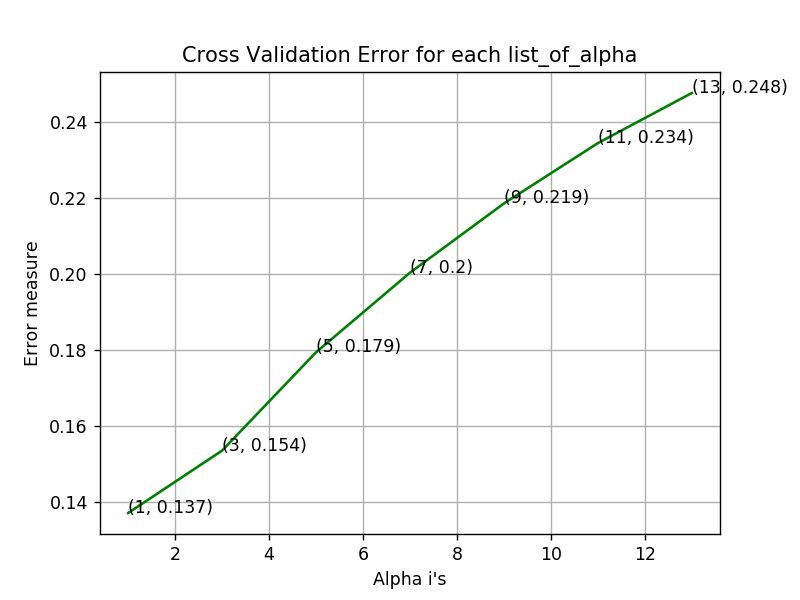

For values of best list_of_alpha =  1 The train log loss is: 0.049338924331024665
For values of best list_of_alpha =  1 The cross validation log loss is: 0.13719967014656467
For values of best list_of_alpha =  1 The test log loss is: 0.1217187948368352
Number of misclassified points  1.9319227230910765
================================================== Confusion matrix ==================================================


<IPython.core.display.Javascript object>


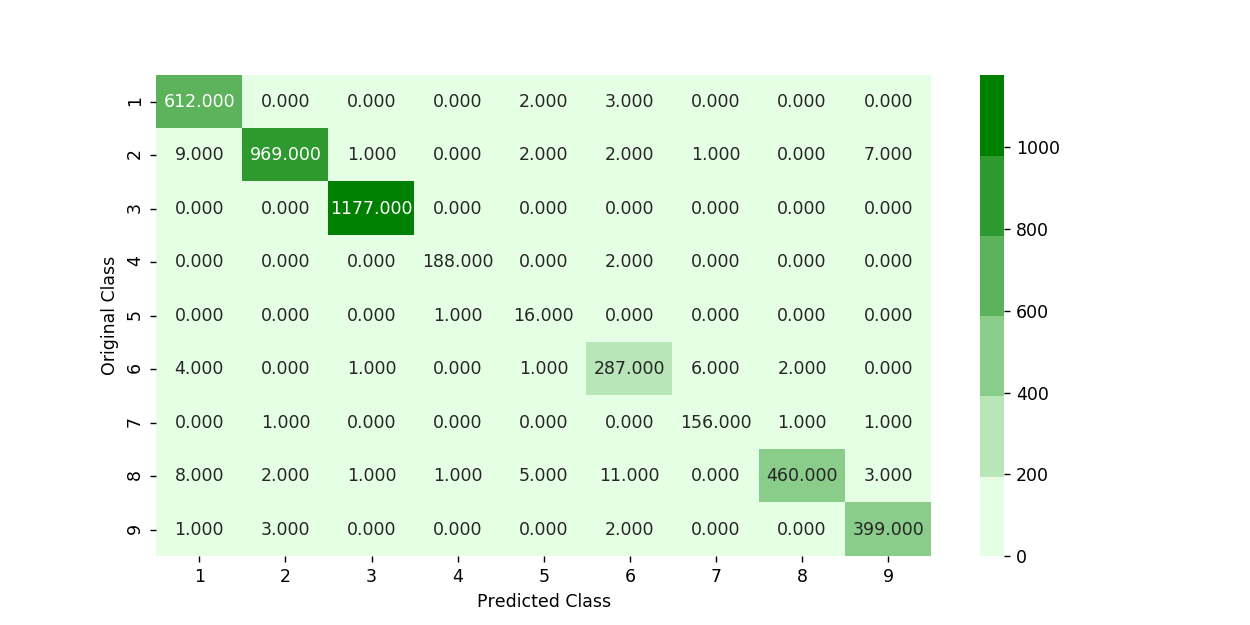

================================================== Precision matrix ==================================================


<IPython.core.display.Javascript object>


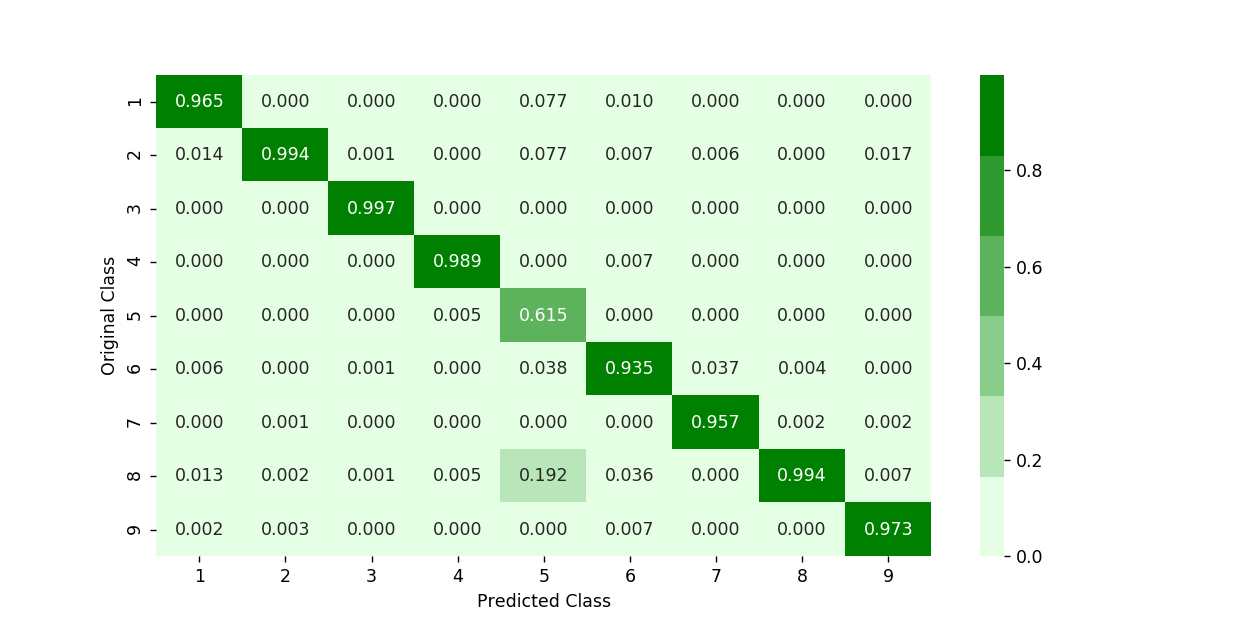

================================================== Recall matrix ==================================================


<IPython.core.display.Javascript object>


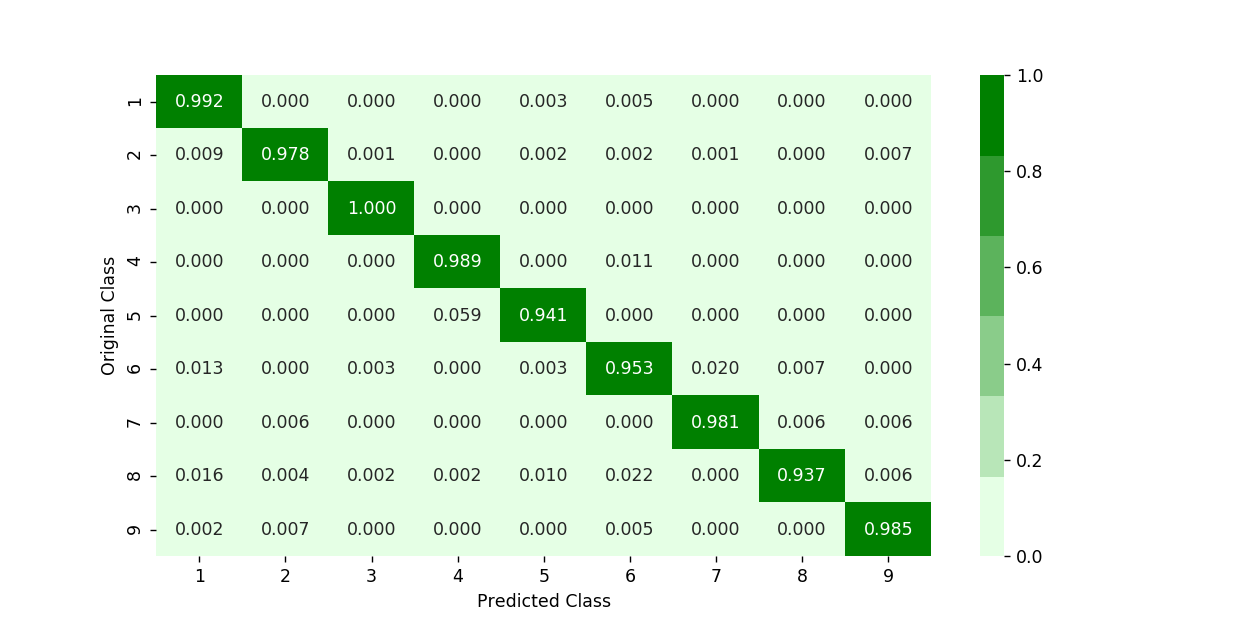

In [11]:

global fig, ax, i, txt


def train_knn():
    global i, k_cfl, sig_clf, predict_y
    for i in list_of_alpha:
        k_cfl = KNeighborsClassifier(n_neighbors=i)
        k_cfl.fit(X_train, y_train)
        sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
        sig_clf.fit(X_train, y_train)
        predict_y = sig_clf.predict_proba(X_cv)
        cv_log_error_values.append(log_loss(y_cv, predict_y, labels=k_cfl.classes_, eps=1e-15))


def print_log_loss():
    global i
    for i in range(len(cv_log_error_values)):
        print('log_loss for k = ', list_of_alpha[i], 'is', cv_log_error_values[i])


def plot_cv_error():
    fig, ax = plt.subplots()
    ax.plot(list_of_alpha, cv_log_error_values, c='g')
    for i, txt in enumerate(np.round(cv_log_error_values, 3)):
        ax.annotate((list_of_alpha[i], np.round(txt, 3)), (list_of_alpha[i], cv_log_error_values[i]))
    plt.grid()
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.title("Cross Validation Error for each list_of_alpha")
    plt.show()


def get_train_test_cv_log_loss():
    global predict_y
    predict_y = sig_clf.predict_proba(X_train)
    print('For values of best list_of_alpha = ', list_of_alpha[index_of_best_alpha], "The train log loss is:",
          log_loss(y_train, predict_y))
    predict_y = sig_clf.predict_proba(X_cv)
    print('For values of best list_of_alpha = ', list_of_alpha[index_of_best_alpha], "The cross validation log loss is:",
          log_loss(y_cv, predict_y))
    predict_y = sig_clf.predict_proba(X_test)
    print('For values of best list_of_alpha = ', list_of_alpha[index_of_best_alpha], "The test log loss is:",
          log_loss(y_test, predict_y))


list_of_alpha = [x for x in range(1, 15, 2)]
cv_log_error_values = []

train_knn()

print_log_loss()

index_of_best_alpha = np.argmin(cv_log_error_values)

plot_cv_error()

k_cfl = KNeighborsClassifier(n_neighbors=list_of_alpha[index_of_best_alpha])
k_cfl.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

get_train_test_cv_log_loss()
plot_confusion_matrix(y_test, sig_clf.predict(X_test))


<h3>  Random Forest Classifier </h3>

log_loss for c =  10 is 0.045182978123549766
log_loss for c =  50 is 0.03621512068415869
log_loss for c =  100 is 0.03649754198050862
log_loss for c =  500 is 0.03496473822651583
log_loss for c =  1000 is 0.034543927745277876
log_loss for c =  2000 is 0.0342358931760652
log_loss for c =  3000 is 0.034243062552583775


<IPython.core.display.Javascript object>


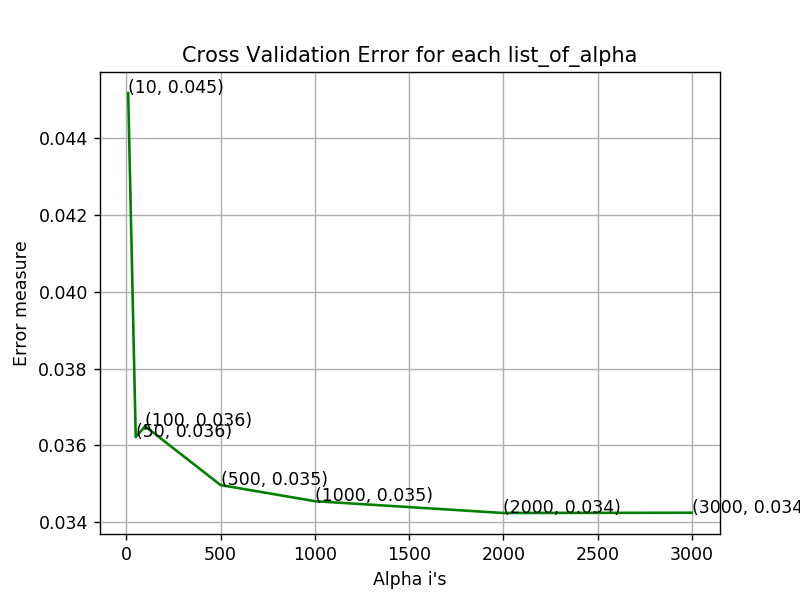

For values of best list_of_alpha =  2000 The train log loss is: 0.01350791518204678
For values of best list_of_alpha =  2000 The cross validation log loss is: 0.0342358931760652
For values of best list_of_alpha =  2000 The test log loss is: 0.030827729253342366
Number of misclassified points  0.5289788408463661
================================================== Confusion matrix ==================================================


<IPython.core.display.Javascript object>


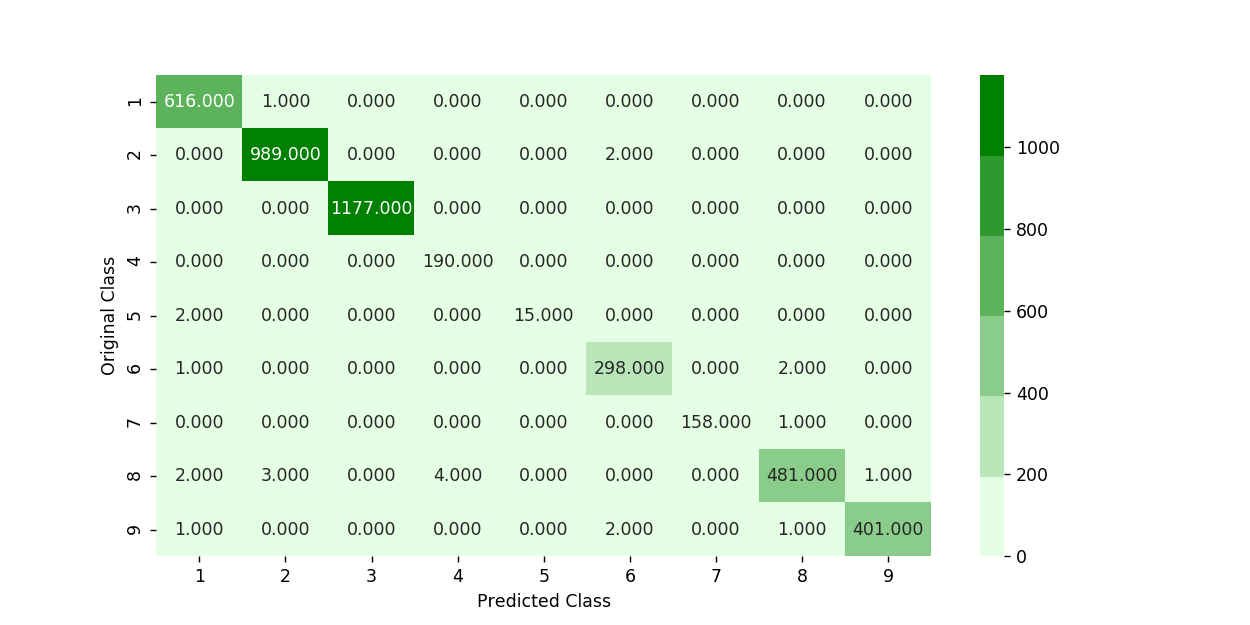

================================================== Precision matrix ==================================================


<IPython.core.display.Javascript object>


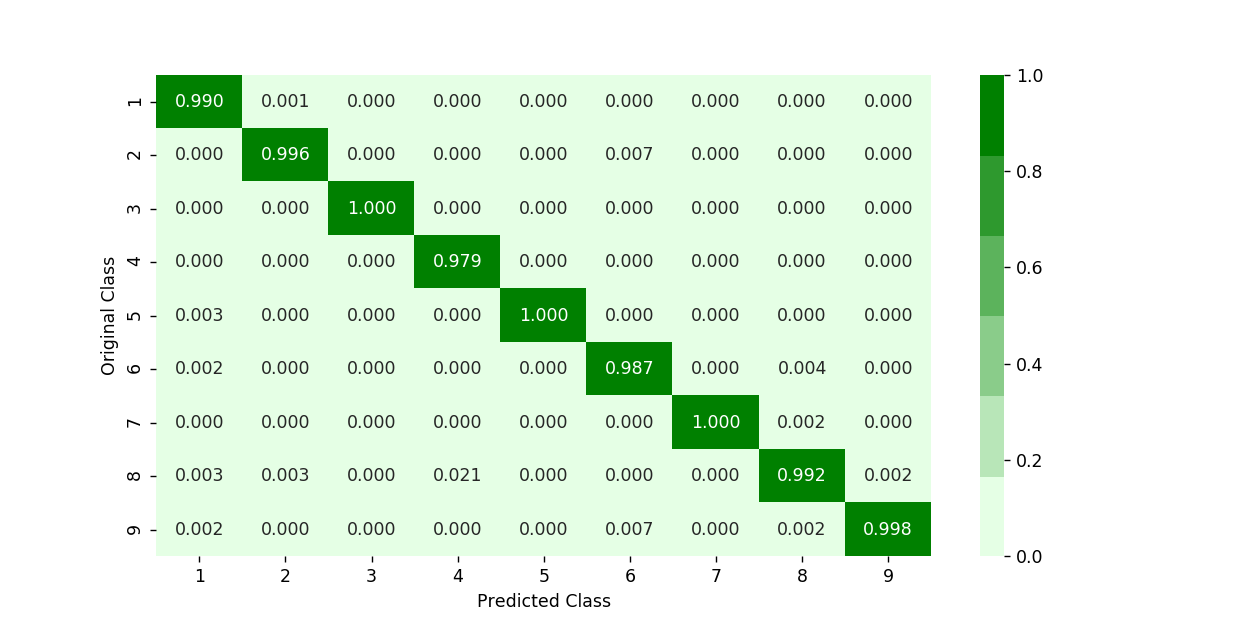

================================================== Recall matrix ==================================================


<IPython.core.display.Javascript object>


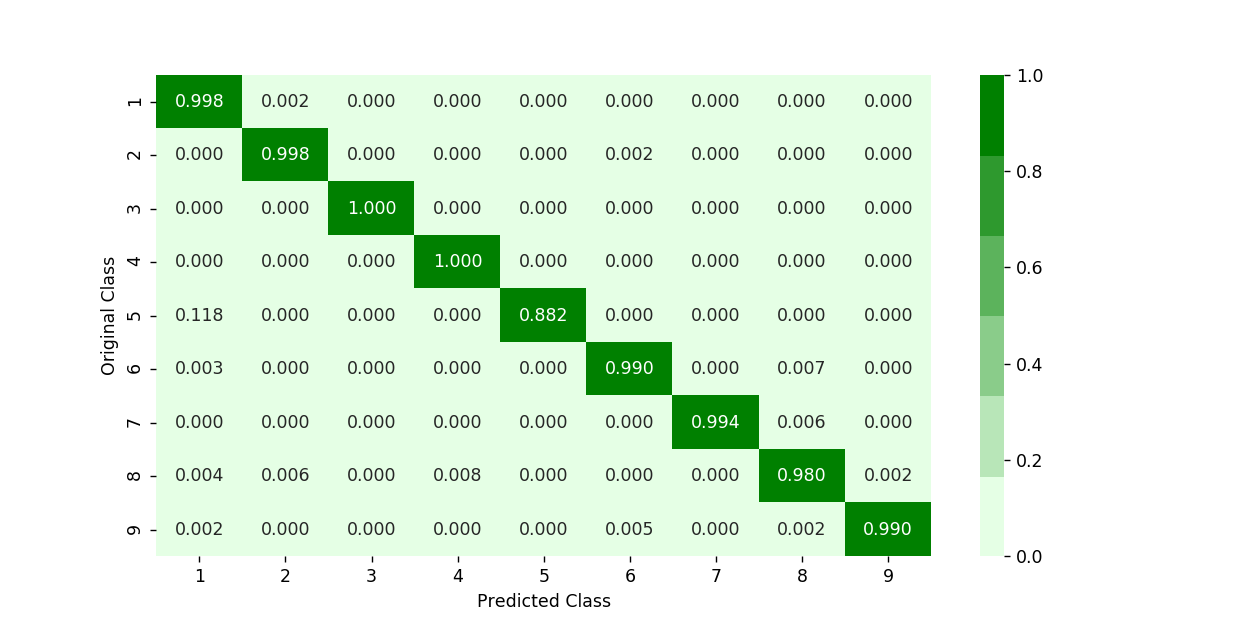

In [12]:

def train_random_forest():
    global i, r_cfl, sig_clf, predict_y
    for i in list_of_alpha:
        r_cfl = RandomForestClassifier(n_estimators=i, random_state=42,
                                       n_jobs=-1)
        r_cfl.fit(X_train, y_train)
        sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
        sig_clf.fit(X_train, y_train)
        predict_y = sig_clf.predict_proba(X_cv)
        cv_log_error_values.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))


list_of_alpha = [10, 50, 100, 500, 1000, 2000, 3000]
cv_log_error_values = []
train_log_error_values = []

train_random_forest()

for i in range(len(cv_log_error_values)):
    print('log_loss for c = ', list_of_alpha[i], 'is', cv_log_error_values[i])

index_of_best_alpha = np.argmin(cv_log_error_values)

# fig, ax = plt.subplots()
# ax.plot(list_of_alpha, cv_log_error_values, c='g')
# for i, txt in enumerate(np.round(cv_log_error_values, 3)):
#     ax.annotate((list_of_alpha[i], np.round(txt, 3)), (list_of_alpha[i], cv_log_error_values[i]))
# plt.grid()
# plt.title("Cross Validation Error for each list_of_alpha")
# plt.xlabel("Alpha i's")
# plt.ylabel("Error measure")
# plt.show()

plot_cv_error()

r_cfl = RandomForestClassifier(n_estimators=list_of_alpha[index_of_best_alpha], random_state=42, n_jobs=-1)
r_cfl.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

# predict_y = sig_clf.predict_proba(X_train)
# print('For values of best list_of_alpha = ', list_of_alpha[index_of_best_alpha], "The train log loss is:", log_loss(y_train, predict_y))
# predict_y = sig_clf.predict_proba(X_cv)
# print('For values of best list_of_alpha = ', list_of_alpha[index_of_best_alpha], "The cross validation log loss is:",
#       log_loss(y_cv, predict_y))
# predict_y = sig_clf.predict_proba(X_test)
# print('For values of best list_of_alpha = ', list_of_alpha[index_of_best_alpha], "The test log loss is:", log_loss(y_test, predict_y))


get_train_test_cv_log_loss()
plot_confusion_matrix(y_test, sig_clf.predict(X_test))


<h3> XgBoost Classification</h3>

log_loss for c =  10 is 0.18766044993799172
log_loss for c =  50 is 0.0862174923528123
log_loss for c =  100 is 0.04679649130739403
log_loss for c =  500 is 0.03452552814666048
log_loss for c =  1000 is 0.03478765079705714
log_loss for c =  2000 is 0.03528712854706514


<IPython.core.display.Javascript object>


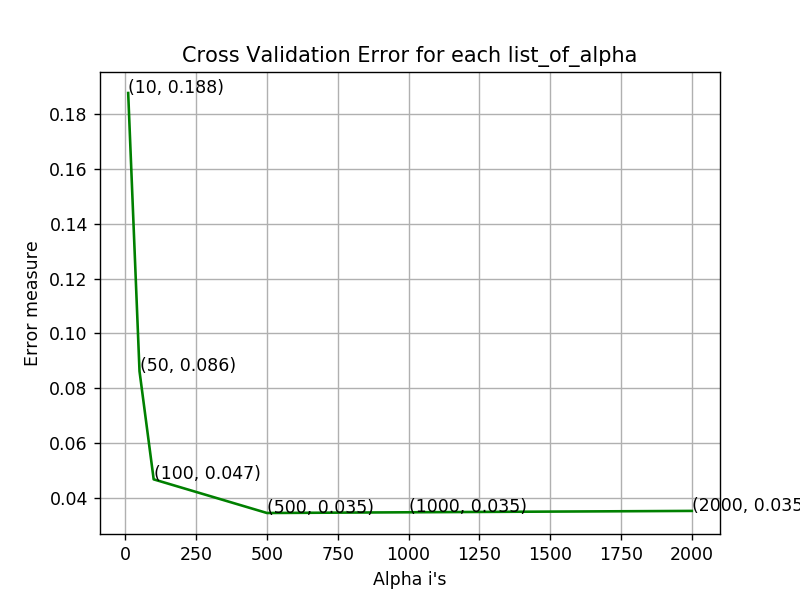

For values of best list_of_alpha =  500 The train log loss is: 0.012274087612131728
For values of best list_of_alpha =  500 The cross validation log loss is: 0.03528712854706514
For values of best list_of_alpha =  500 The test log loss is: 0.02929669319249174
Number of misclassified points  0.5059797608095675
================================================== Confusion matrix ==================================================


<IPython.core.display.Javascript object>


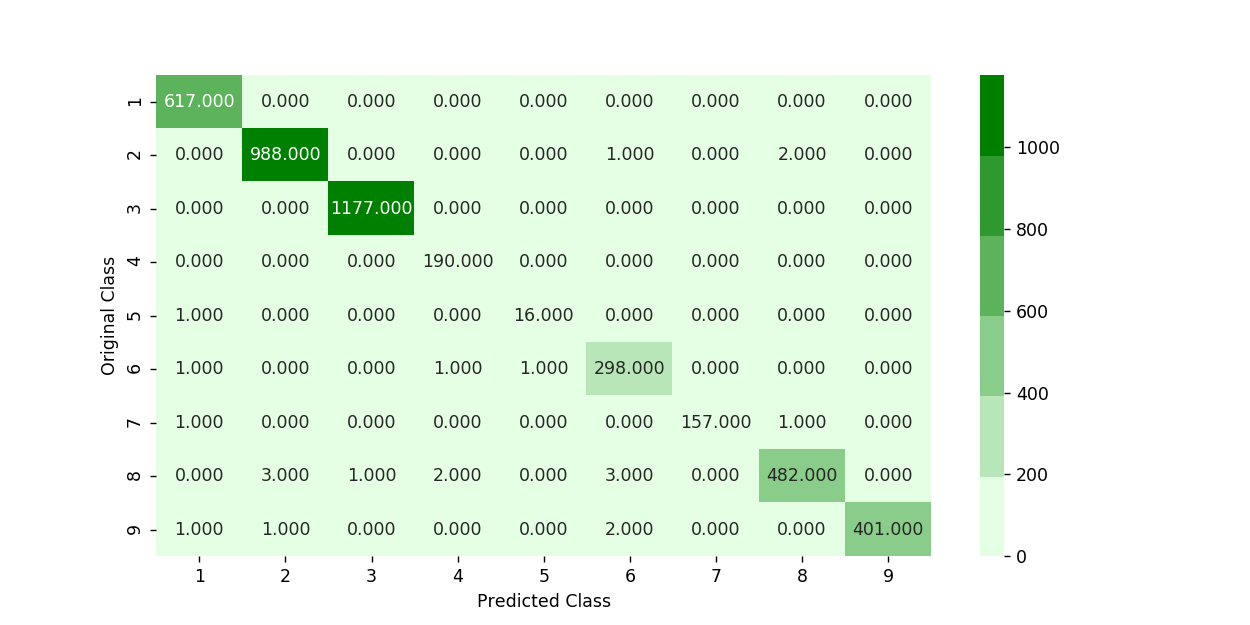

================================================== Precision matrix ==================================================


<IPython.core.display.Javascript object>


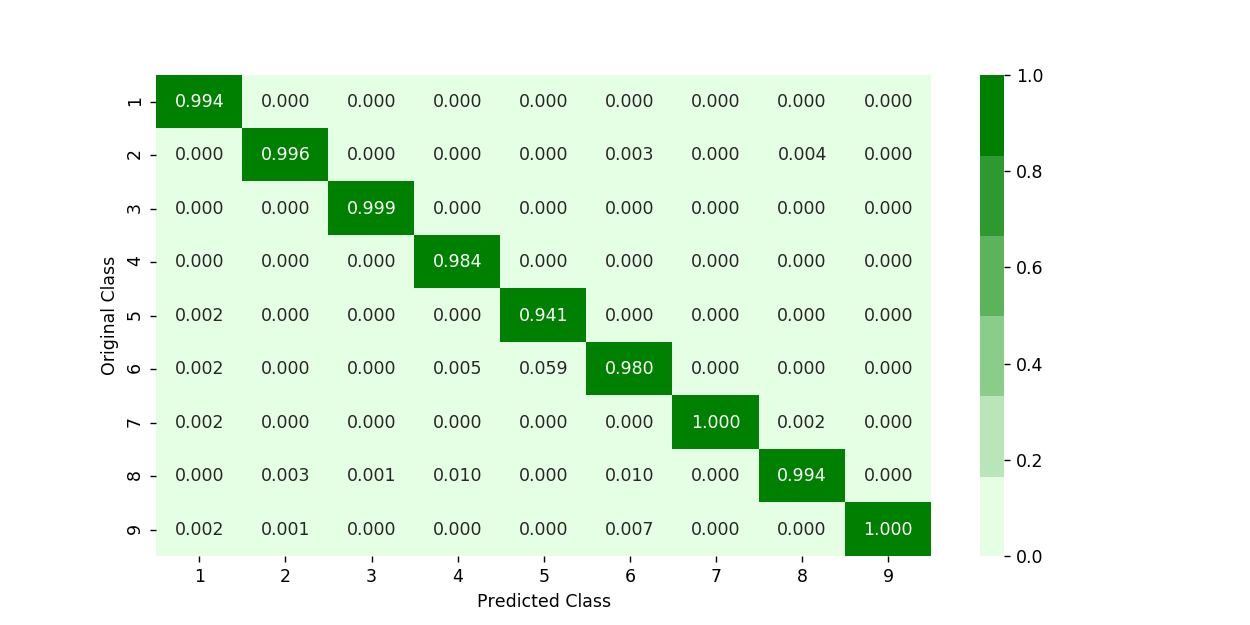

================================================== Recall matrix ==================================================


<IPython.core.display.Javascript object>


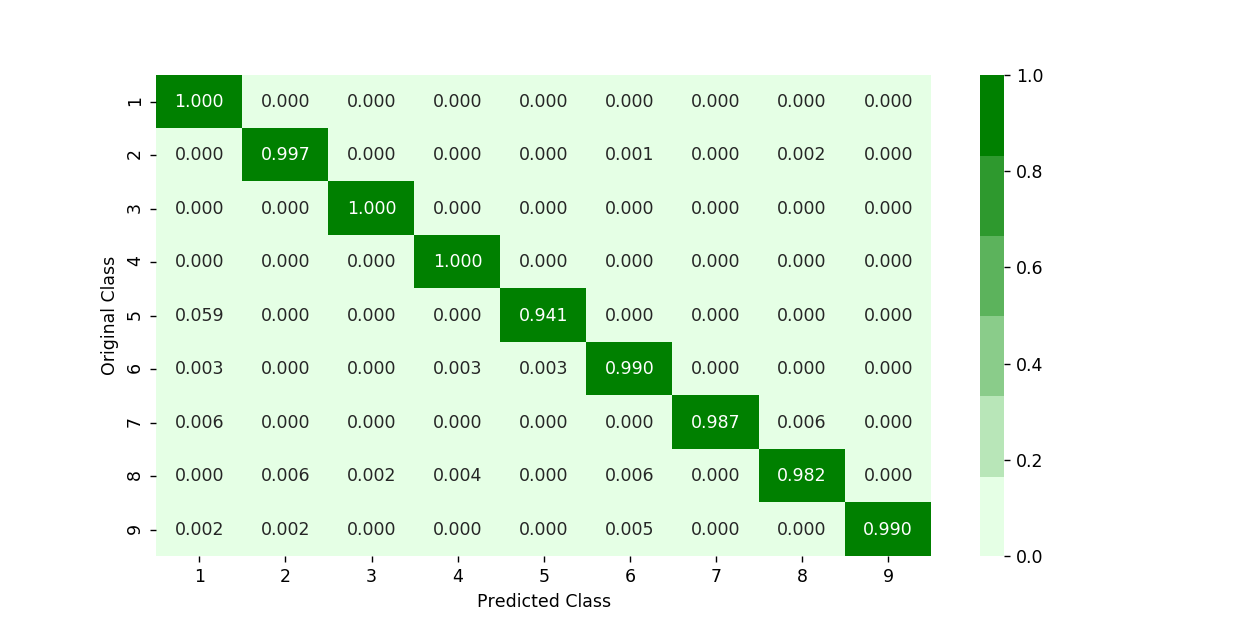

In [13]:

list_of_alpha = [10, 50, 100, 500, 1000, 2000]
cv_log_error_values = []
for i in list_of_alpha:
    xgb_clf = XGBClassifier(n_estimators=i, nthread=-1)
    xgb_clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(xgb_clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_values.append(log_loss(y_cv, predict_y, labels=xgb_clf.classes_, eps=1e-15))

for i in range(len(cv_log_error_values)):
    print('log_loss for c = ', list_of_alpha[i], 'is', cv_log_error_values[i])

index_of_best_alpha = np.argmin(cv_log_error_values)

plot_cv_error()

get_train_test_cv_log_loss()

plot_confusion_matrix(y_test, sig_clf.predict(X_test))


<h3> XgBoost Classification using RandomSearch to find best hyper parameters</h3>

In [14]:


xgb_clf = XGBClassifier()

params = {
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 5, 10],
    'colsample_bytree': [0.1, 0.3, 0.5, 1],
    'n_estimators': [100, 200, 500, 1000, 2000],
    'subsample': [0.1, 0.3, 0.5, 1]
}
random_search_clf = RandomizedSearchCV(xgb_clf, param_distributions=params, verbose=10, n_jobs=-1)
random_search_clf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 22.4min remaining: 13.0min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 27.5min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 39.0min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 41.6min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2], 'max_depth': [3, 5, 10], 'colsample_bytree': [0.1, 0.3, 0.5, 1], 'n_estimators': [100, 200, 500, 1000, 2000], 'subsample': [0.1, 0.3, 0.5, 1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=10)

In [15]:
print (random_search_clf.best_params_)

{'subsample': 0.5, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.15, 'colsample_bytree': 0.5}


In [17]:

xgb_clf = XGBClassifier(n_estimators=200, learning_rate=0.15, colsample_bytree=0.5, max_depth=10, subsample= 0.5)
xgb_clf.fit(X_train, y_train)
c_cfl = CalibratedClassifierCV(xgb_clf, method='sigmoid')
c_cfl.fit(X_train, y_train)

predict_y = c_cfl.predict_proba(X_train)
print('train loss', log_loss(y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv)
print('cv loss', log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)
print('test loss', log_loss(y_test, predict_y))

train loss 0.012053495211698054
cv loss 0.03220578372091902
test loss 0.026400667651569704
